**3.** Hierarchical models and multiple comparisons:

**(a)** Reproduce the computations in Section 5.5 for the educational testing example. Use
the posterior simulations to estimate (i) for each school $j$, the probability that its
coaching program is the best of the eight; and (ii) for each pair of schools, $j$ and $k$,
the probability that the coaching program in school $j$ is better than that in school $k$.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import random
import seaborn as sns
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# y is the estimated treatment effect
# s is the standard error of effect estimate
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
s = np.array([15, 10, 16, 11,  9, 11, 10, 18])
J = len(y)

In [4]:
def post_tau(tau, y, s):
    # Eqs. 5.20 and 5.21 on the book, marginal posterior density for tau
    num = np.sum(1/(s**2 + tau**2))
    mu_hat = np.sum(y/(s**2 + tau**2)) / num
    V_mu = 1 / num
    p = np.sqrt(V_mu)*np.prod(1/np.sqrt(s**2 + tau**2)) * np.exp(-0.5*np.sum((y-mu_hat)**2/(s**2 + tau**2)))
    return p

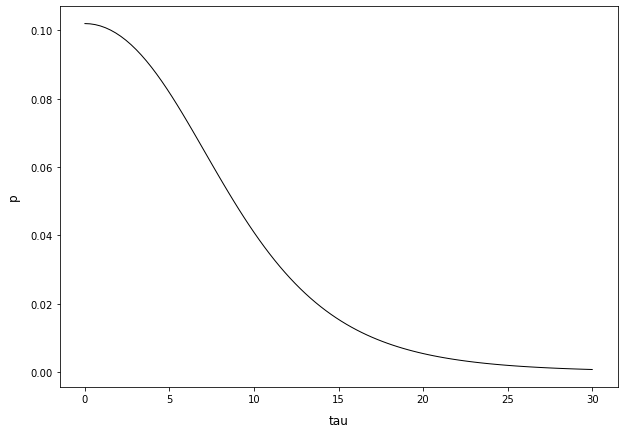

In [5]:
#Plotting marginal distribution for tau
tau = np.linspace(0.001, 30, 100)
p = [post_tau(i, y, s) for i in tau]
delta = np.diff(tau[:2])
p = p / np.sum(p*delta)

plt.figure(figsize = (10,7))
plt.plot(tau, p, 'black', lw = 1)
plt.ylabel('p', fontsize = 12, labelpad = 10)
plt.xlabel('tau', fontsize = 12, labelpad = 10);

In [6]:
# Simulation. Tau and mu
M = 10000
tau_sim = np.array(random.choices(tau, k = M, weights = p))
len(sorted(tau_sim))
mu_hat, V_mu = [], []
for i in range(M):
    num = np.sum(1/(s**2 + tau_sim[i]**2))
    mu_hat.append(np.sum(y/(s**2 + tau_sim[i]**2)) / num)
    V_mu.append(1 / num)
    
mu_sim = st.norm.rvs(mu_hat, np.sqrt(V_mu), size = M)

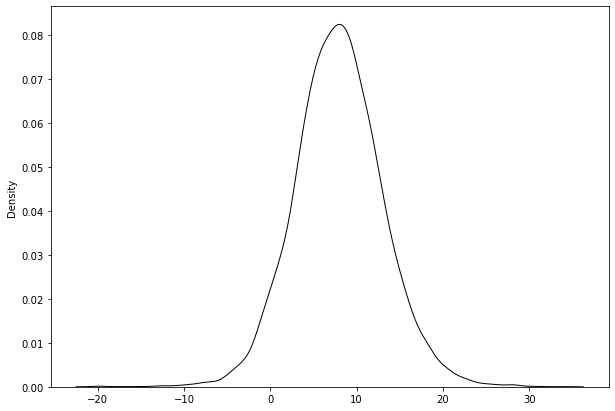

In [7]:
plt.figure(figsize = (10,7))
sns.distplot(mu_sim, hist=False, color = 'black', kde=True,kde_kws={'linewidth': 1});

In [8]:
# Simulate theta_j
s2_inv = 1 / s**2
tau2_inv = 1 / tau_sim**2
theta_hat = np.zeros((M, J))
theta_sim = np.zeros((M, J))
for m in range(M):
    theta_hat[m,:] = (s2_inv*y+tau2_inv[m]*mu_sim[m])/(s2_inv+tau2_inv[m])
    V_theta = 1/(s2_inv+tau2_inv[m])
    theta_sim[m,:] = st.norm.rvs(theta_hat[m,],np.sqrt(V_theta), size = J)

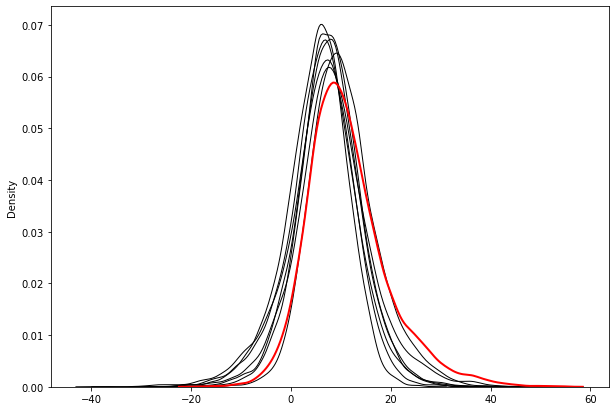

In [9]:
plt.figure(figsize = (10,7))
for i in range(1, J):
    sns.distplot(theta_sim[:, i], hist=False, color = 'black', kde=True,kde_kws={'linewidth': 1})
sns.distplot(theta_sim[:, 0], hist=False, color = 'red', kde=True,kde_kws={'linewidth': 2})
plt.show()

In [10]:
quantiles = np.round(np.quantile(theta_sim, [0.025,0.25,0.5,0.75,0.975], axis = 0).T)

In [11]:
df = pd.DataFrame(data = quantiles,
                  index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
                  columns = ['2.5%','25%','50%','75%','97.5%'])
print(df)

   2.5%  25%   50%   75%  97.5%
A  -2.0  6.0  10.0  15.0   31.0
B  -4.0  4.0   8.0  12.0   20.0
C -11.0  2.0   7.0  11.0   21.0
D  -5.0  4.0   8.0  12.0   21.0
E  -9.0  2.0   6.0   9.0   16.0
F  -9.0  2.0   6.0  10.0   18.0
G  -1.0  6.0  10.0  14.0   26.0
H  -7.0  4.0   8.0  13.0   26.0


In [12]:
prob_max = [np.mean(theta_sim[:, i] == np.max(theta_sim, axis = 1)) for i in range(J)]
prob_max

[0.2482, 0.1001, 0.0831, 0.1006, 0.051, 0.068, 0.2047, 0.1443]

In [13]:
#Pairwise probabilities
Pm = np.zeros((8,8))
for i in range(Pm.shape[0]):
    for j in range(Pm.shape[1]):
        Pm[i, j] = np.mean(theta_sim[:, i] > theta_sim[:, j])

In [14]:
np.round(Pm, 2)

array([[0.  , 0.64, 0.67, 0.64, 0.73, 0.69, 0.52, 0.6 ],
       [0.36, 0.  , 0.56, 0.51, 0.63, 0.58, 0.38, 0.48],
       [0.33, 0.44, 0.  , 0.45, 0.56, 0.51, 0.33, 0.42],
       [0.36, 0.49, 0.55, 0.  , 0.62, 0.57, 0.37, 0.46],
       [0.27, 0.37, 0.44, 0.38, 0.  , 0.45, 0.27, 0.36],
       [0.31, 0.42, 0.49, 0.43, 0.55, 0.  , 0.31, 0.4 ],
       [0.48, 0.62, 0.67, 0.63, 0.73, 0.69, 0.  , 0.59],
       [0.4 , 0.52, 0.58, 0.54, 0.64, 0.6 , 0.41, 0.  ]])

**(b)** Repeat (a), but for the simpler model with $τ$ set to $\infty$ (that is, separate estimation
for the eight schools). In this case, the probabilities (i) and (ii) can be computed
analytically.

In [15]:
theta_sim2 = st.norm.rvs(y, s, size = (M,J))
print(np.round(np.mean(theta_sim2, axis = 0), 2))
prob_max2 = [np.mean(theta_sim2[:, i] == np.max(theta_sim2, axis = 1)) for i in range(J)]
prob_max2

[27.89  7.94 -3.25  6.95 -1.08  0.81 17.77 12.04]


[0.5502, 0.0322, 0.0261, 0.0372, 0.0029, 0.0143, 0.1669, 0.1702]